
# Dimentionality Reduction

## Modified example

Original found here: https://github.com/jakevdp/sklearn_pycon2015/blob/master/notebooks/04.1-Dimensionality-PCA.ipynb

Jake Vanderplas: [@jakevdp](https://twitter.com/jakevdp)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid') 
plt.rcParams['figure.figsize'] = 12, 8  # plotsize 

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits

from IPython.html.widgets import interact

:0: FutureWarning: IPython widgets are experimental and may change in the future.


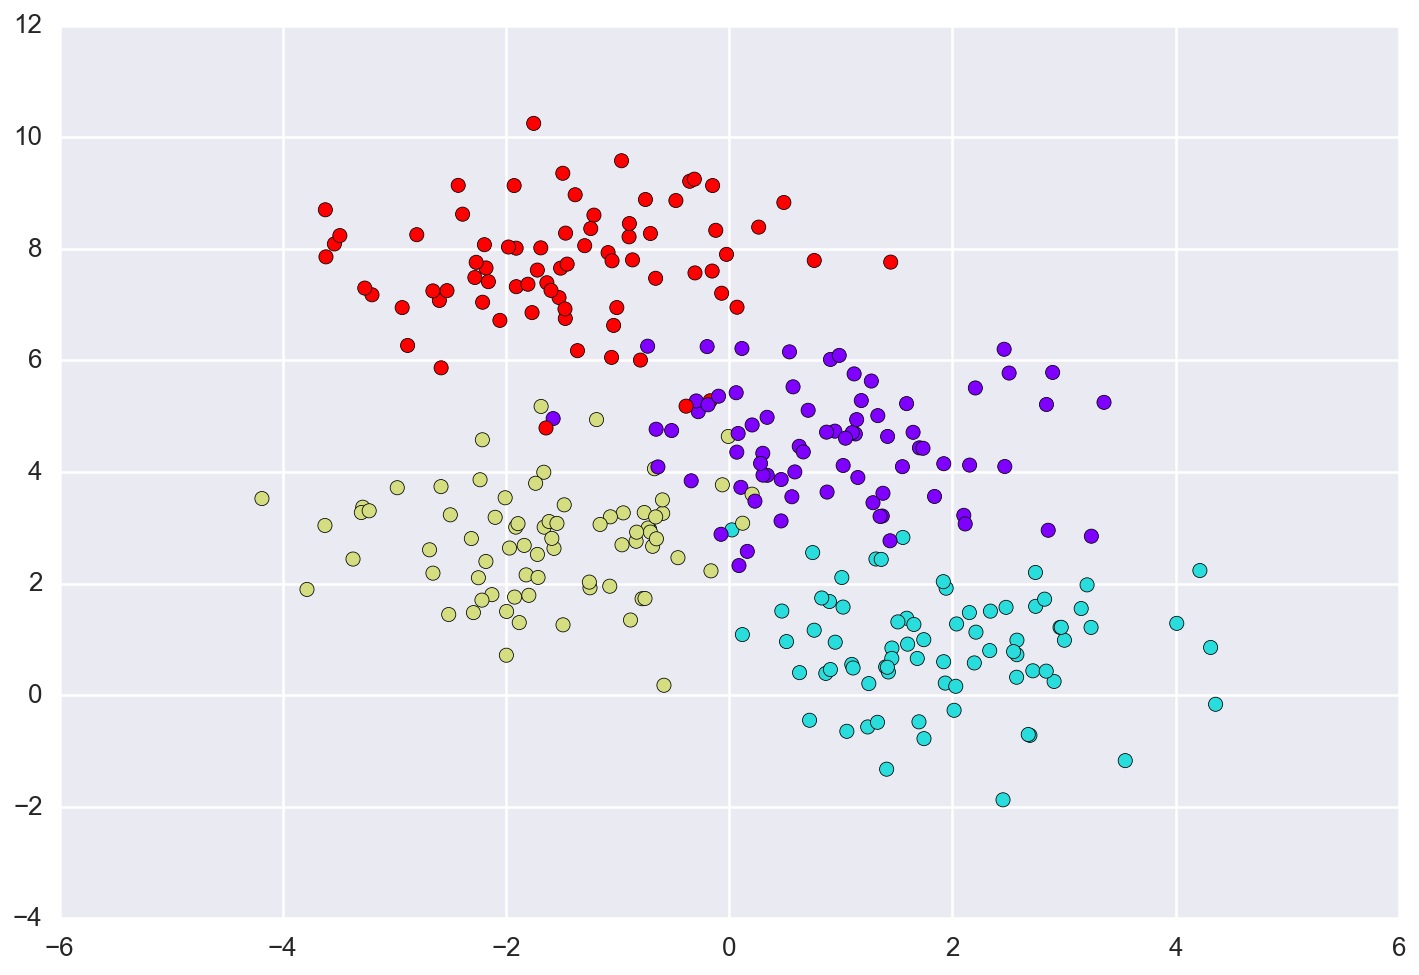

In [2]:
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow'); 

In [3]:
def visualize_tree(estimator, X, y, boundaries=True,
                   xlim=None, ylim=None):
    estimator.fit(X, y)

    if xlim is None:
        xlim = (X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
    if ylim is None:
        ylim = (X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)

    x_min, x_max = xlim
    y_min, y_max = ylim
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, alpha=0.2, cmap='rainbow')
    plt.clim(y.min(), y.max())

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')
    plt.axis('off')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)        
    plt.clim(y.min(), y.max())
    
    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i < 0:
            return

        tree = estimator.tree_
        
        if tree.feature[i] == 0:
            plt.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k')
            plot_boundaries(tree.children_left[i],
                            [xlim[0], tree.threshold[i]], ylim)
            plot_boundaries(tree.children_right[i],
                            [tree.threshold[i], xlim[1]], ylim)
        
        elif tree.feature[i] == 1:
            plt.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k')
            plot_boundaries(tree.children_left[i], xlim,
                            [ylim[0], tree.threshold[i]])
            plot_boundaries(tree.children_right[i], xlim,
                            [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, plt.xlim(), plt.ylim())


def plot_tree_interactive(X, y):
    from sklearn.tree import DecisionTreeClassifier

    def interactive_tree(depth=1):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        visualize_tree(clf, X, y)

    from IPython.html.widgets import interact
    return interact(interactive_tree, depth=[1, 5])


In [4]:
def fit_randomized_tree(random_state=0):
    X, y = make_blobs(n_samples=300, centers=4,
                      random_state=0, cluster_std=2.0)
    clf = DecisionTreeClassifier(max_depth=15)
    
    rng = np.random.RandomState(random_state)
    i = np.arange(len(y))
    rng.shuffle(i)
    visualize_tree(clf, X[i[:250]], y[i[:250]], boundaries=False,
                   xlim=(X[:, 0].min(), X[:, 0].max()),
                   ylim=(X[:, 1].min(), X[:, 1].max()))

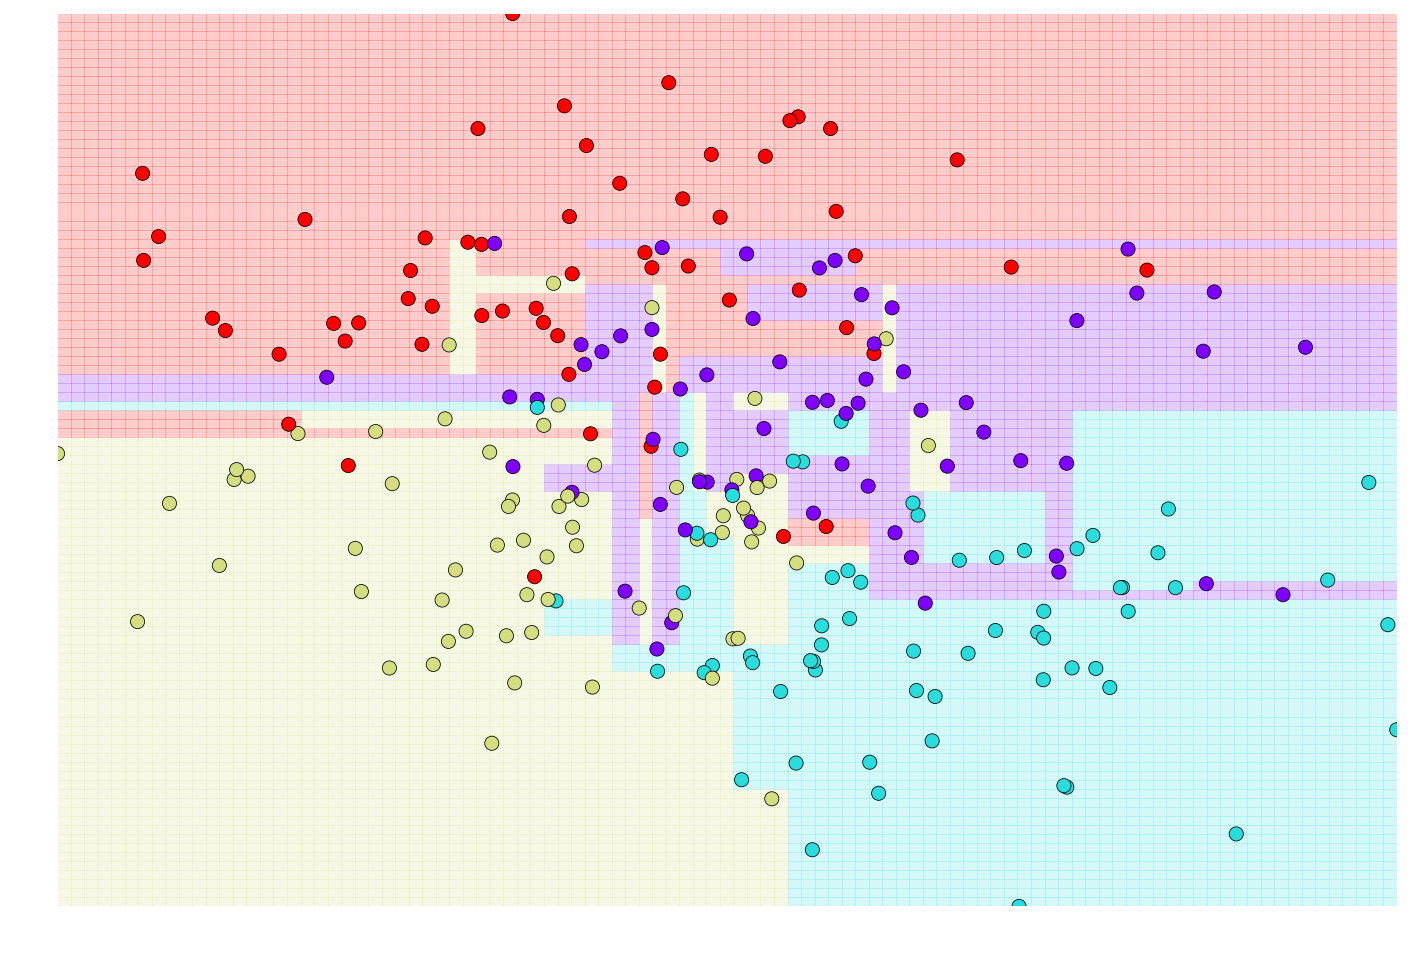

In [5]:
interact(fit_randomized_tree, random_state=[0, 100]); 

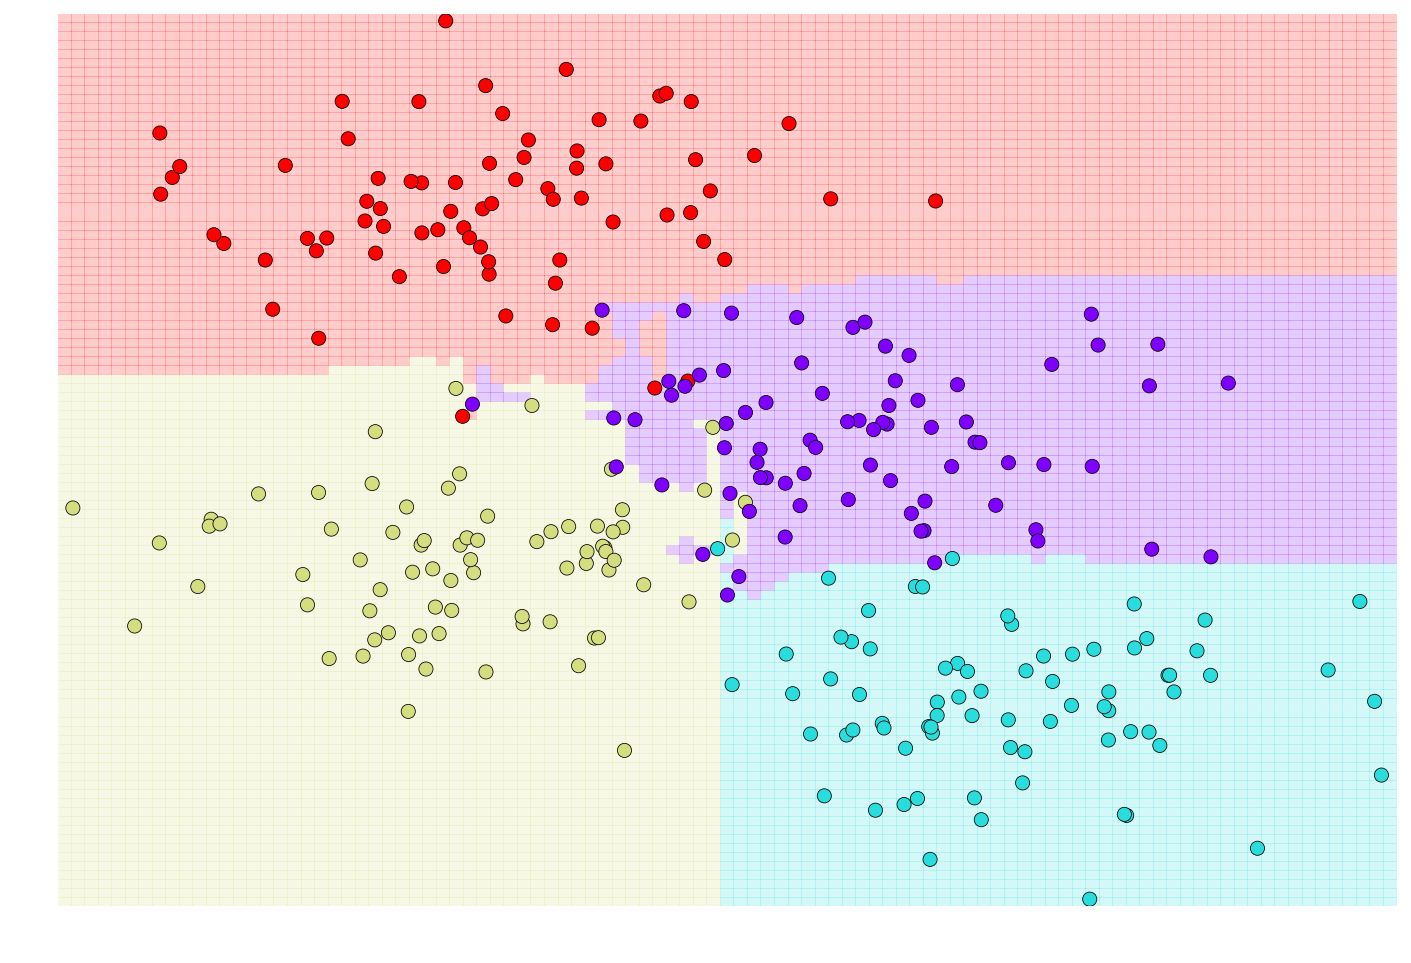

In [7]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_tree(clf, X, y, boundaries=False); 

## Regression 

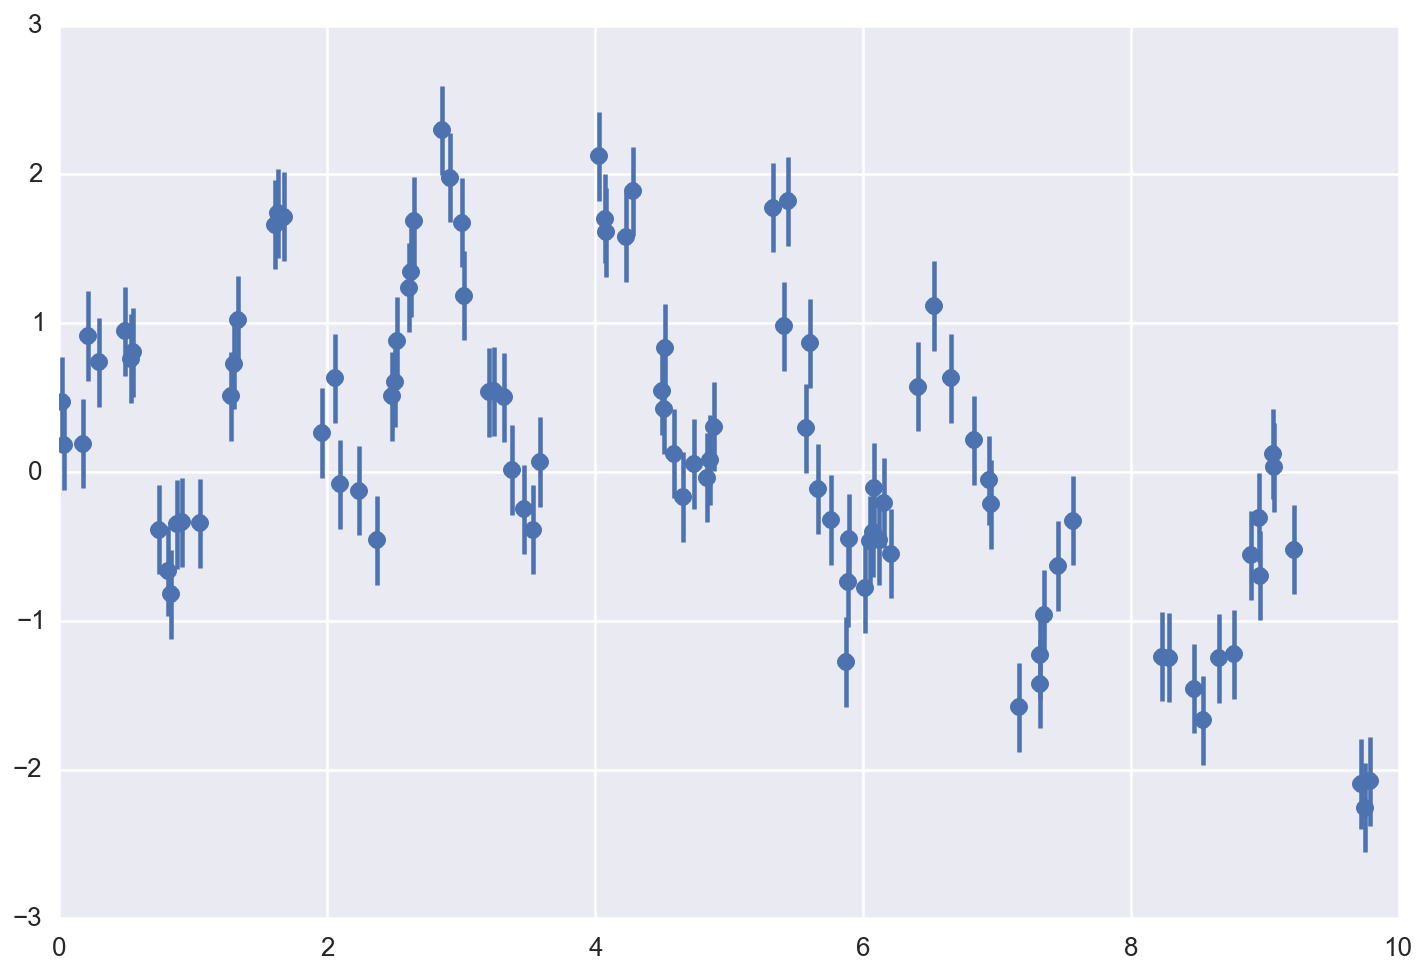

In [8]:
x = 10 * np.random.rand(100)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * np.random.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

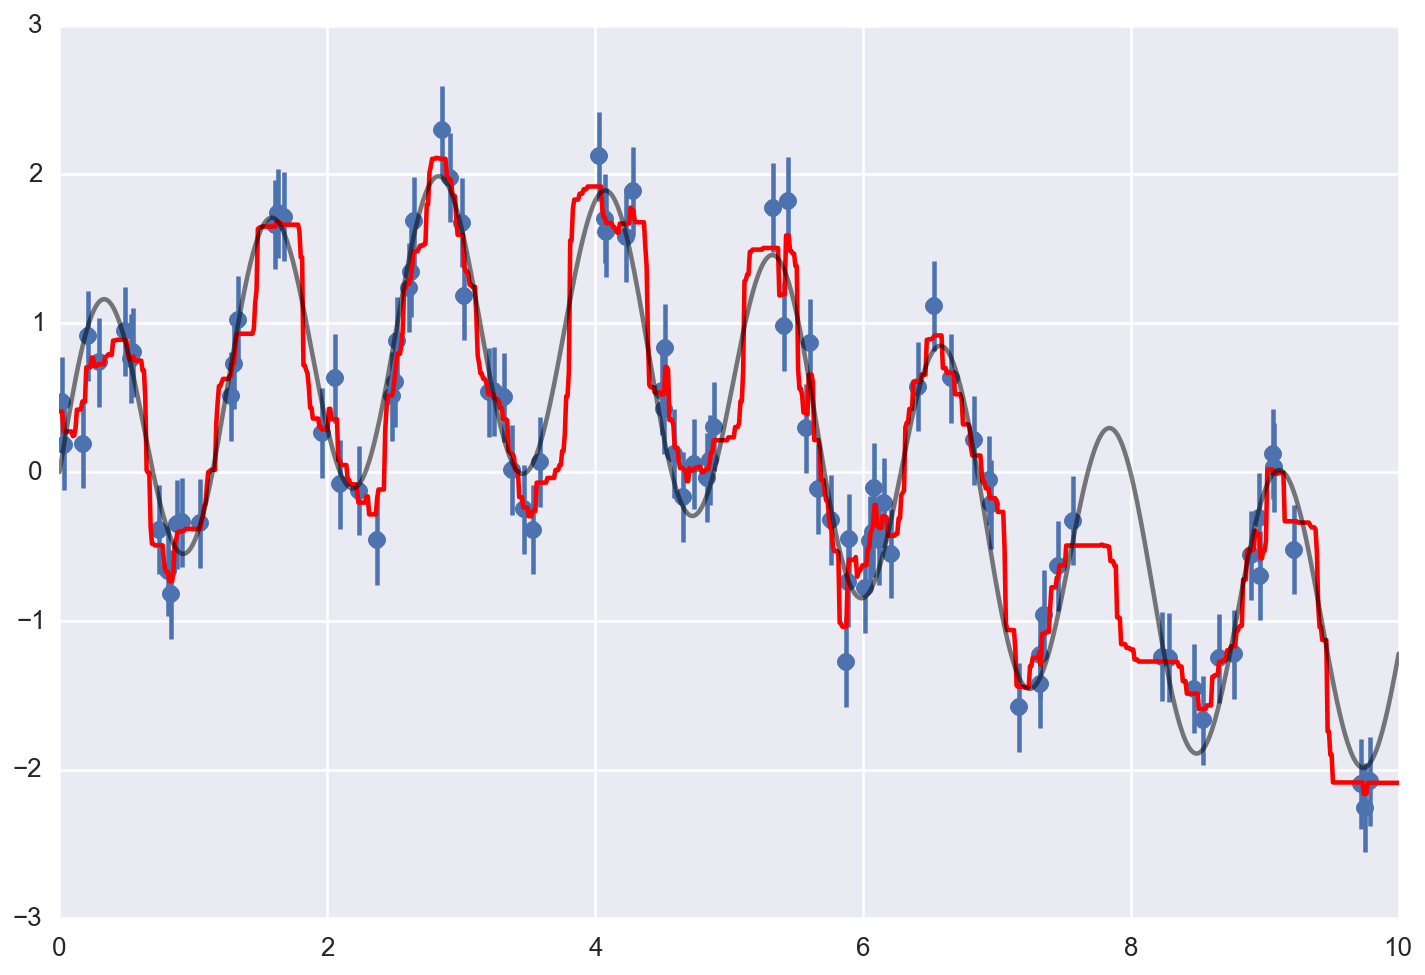

In [9]:
xfit = np.linspace(0, 10, 1000)
yfit = RandomForestRegressor(100).fit(x[:, None], y).predict(xfit[:, None])
ytrue = model(xfit, 0)

plt.errorbar(x, y, 0.3, fmt='o')
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5); 

## Residuals!

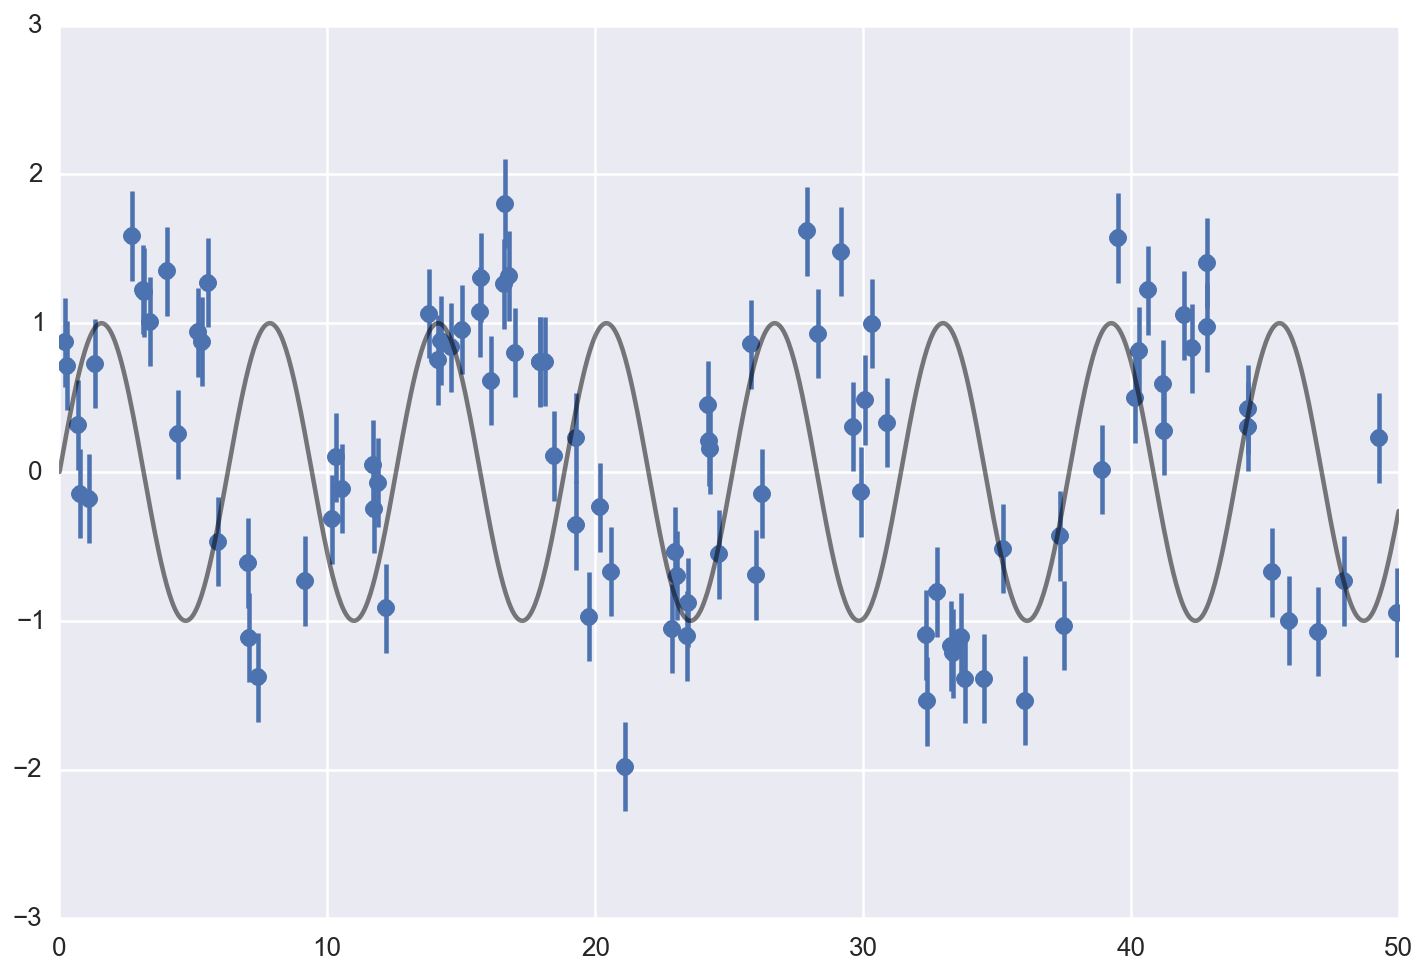

In [21]:
upper_x = 50
x = upper_x * np.random.rand(100)
xfit = np.linspace(0, upper_x, 1000)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * np.random.randn(len(x))

    return slow_oscillation + 0.5 * fast_oscillation + noise

y = model(x)
# plt.plot(x, y)
ywrong = np.sin(xfit)
plt.errorbar(x, y, 0.3, fmt='o');
plt.plot(xfit, ywrong, '-k', alpha=0.5); 

#PCA

In [10]:
digits = load_digits()
X = digits.data
y = digits.target 

In [11]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, n_components=2, whiten=False)

In [12]:
def plot_digits(n_components):
    fig = plt.figure(figsize=(8, 8))
    plt.subplot(1, 1, 1, frameon=False, xticks=[], yticks=[])
    nside = 10
    
    pca = PCA(n_components).fit(X)
    Xproj = pca.inverse_transform(pca.transform(X[:nside ** 2]))
    Xproj = np.reshape(Xproj, (nside, nside, 8, 8))
    total_var = pca.explained_variance_ratio_.sum()
    
    im = np.vstack([np.hstack([Xproj[i, j] for j in range(nside)])
                    for i in range(nside)])
    plt.imshow(im)
    plt.grid(False)
    plt.title("n = {0}, variance = {1:.2f}".format(n_components, total_var),
                 size=18)
    plt.clim(0, 16)

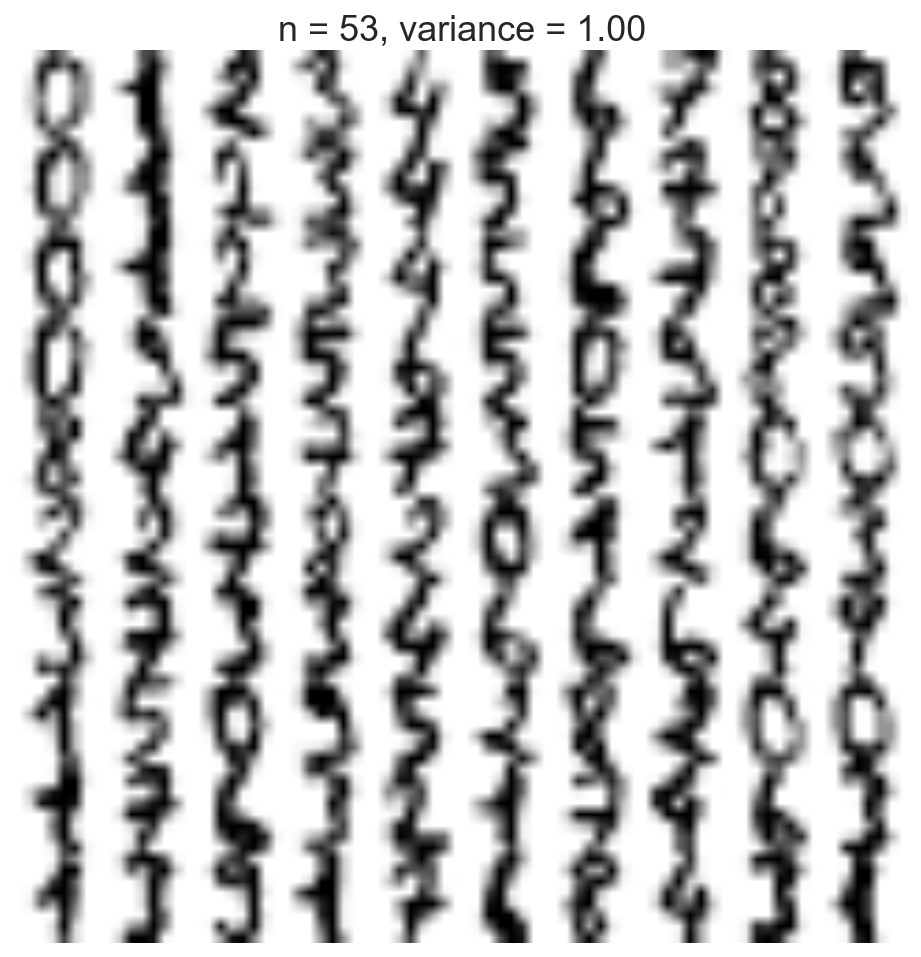

In [13]:
interact(plot_digits, n_components=[1, 64], nside=[1, 8]);

In [ ]:
FileLink("Overview.ipynb")

## License

Copyright (c) 2015, Jake Vanderplas
All rights reserved.

Redistribution and use in source and binary forms, with or without modification,
are permitted provided that the following conditions are met:

  Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

  Redistributions in binary form must reproduce the above copyright notice, this
  list of conditions and the following disclaimer in the documentation and/or
  other materials provided with the distribution.

  Neither the name of the {organization} nor the names of its
  contributors may be used to endorse or promote products derived from
  this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR
ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
(INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON
ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
(INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.